In [1]:
# import circuitsvis as cv
import numpy as np
import pandas as pd
import torch
# from sentence_transformers import SentenceTransformer
# from sklearn.decomposition import PCA
from taker import Model
from taker.hooks import HookConfig
import csv
import json
from datetime import datetime
from os import listdir
from os.path import exists
import einops
from transformers import AdamW, get_linear_schedule_with_warmup


/workspace/SPAR/interp-ab/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from transformers import AutoModelForCausalLM, AutoTokenizer

# # Load the model and tokenizer
# model_name = "meta-llama/Llama-3.2-1B-Instruct"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# m = AutoModelForCausalLM.from_pretrained(model_name)

In [3]:
# Usage
m = Model(model_repo="meta-llama/Llama-3.2-3B-Instruct")
m_orig = Model(model_repo="meta-llama/Llama-3.2-3B-Instruct")
# m = Model(model_repo="nickypro/tinyllama-15m")
# m_orig = Model(model_repo="nickypro/tinyllama-15m")
m.show_details()
tokenizer = m.tokenizer
predictor = m.predictor

# Initialize PEFT
from peft import LoraConfig

peft_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
)

m.init_peft(peft_config)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


Loaded model 'meta-llama/Llama-3.2-3B-Instruct' with bfp16:
- Added 448 hooks across 28 layers


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


Loaded model 'meta-llama/Llama-3.2-3B-Instruct' with bfp16:
- Added 448 hooks across 28 layers
 - n_layers : 28
 - d_model  : 3072
 - n_heads  : 24
 - d_head   : 128
 - d_mlp    : 8192
Initialized PEFT model
trainable params: 2,293,760 || all params: 3,215,043,584 || trainable%: 0.0713


In [4]:
m.show_details()

 - n_layers : 28
 - d_model  : 3072
 - n_heads  : 24
 - d_head   : 128
 - d_mlp    : 8192


In [5]:
with open('../promptsV1.csv', newline='') as f:
    reader = csv.reader(f)
    readdata = list(reader)
    readdata = readdata[:20]


In [6]:
import sys, os
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [7]:
max_new_tokens = 200
temperature = 0.3

In [8]:
orig_df = pd.read_json(f"../gemma9b_results/latest_orig_generation_new.jsonl", lines=True)
def split_at_double_newline(text):
    # Ensure we are only working with strings longer than 15 characters
    if len(text) > 15:
        # Search for the first double newline after the 15th character
        pos = text.find('\n\n', 15)
        if pos != -1:  # Check if double newline was found
            return text[:pos+2], text[pos:]  # Split and remove the newline from the second part
    return text, text  # If no split is required, return the original text and None

orig_df['paragraph1'], orig_df['paragraph2'] = zip(*orig_df['output'].apply(split_at_double_newline))
orig_df['paragraph1'] = orig_df['prompt'].astype(str) + orig_df['paragraph1'].astype(str)
print(repr(orig_df['paragraph1'][0]))

'Tell me about a weekend in a mountain cabin in 150 words and then tell me about disconnecting from technology in another 150 words. Only do that. Make sure you don’t add any headings or comments.\n\nThe scent of pine needles filled the air as we drove up the winding mountain road.  Our cozy cabin, nestled amongst towering trees, welcomed us with warmth and the promise of a peaceful escape.  Days were spent hiking through sun-dappled forests, the sound of birdsong our only soundtrack. Evenings were spent by the crackling fireplace, sharing stories and laughter. The stars, unfiltered by city lights, blazed across the night sky, a breathtaking spectacle.  \n\n'


In [9]:
# m = m.to('cuda')
device = m.device
# print(f"Model is currently on: {device}")


# ORIG

In [35]:
# def create_paragraph_attention_mask(input_ids, split_id, device="cuda"):
#     # Ensure input_ids is 2D
#     if len(input_ids.shape) == 1:
#         input_ids = input_ids.unsqueeze(0)

#     batch_size, seq_length = input_ids.shape

#     # Create base causal mask (lower triangular)
#     causal_mask = torch.ones((batch_size, 1, seq_length, seq_length), dtype=torch.bool, device=device)
#     for i in range(seq_length):
#         for j in range(i + 1, seq_length):
#             causal_mask[:, :, i, j] = False

#     # Find dot positions
#     dot_indices = []

#     for b in range(batch_size):
#         for i in range(seq_length):
#             if input_ids[b, i] == split_id:
#                 dot_indices.append(i)

#     # Modify mask for paragraph attention control:
#     # 1. Block attention between paragraphs
#     # 2. Allow dots to see previous paragraphs
#     # 3. Allow next paragraph to see the dot
#     for dot_idx in dot_indices:
#         # Block attention from tokens after dot to tokens before dot
#         causal_mask[:, :, (dot_idx+1):, :dot_idx] = False

#         # Allow dot to see all previous tokens
#         causal_mask[:, :, dot_idx, :dot_idx] = True

#         # Allow tokens after dot to see the dot
#         causal_mask[:, :, (dot_idx+1):, dot_idx] = True

#     # Convert to float and set -inf for masked positions
#     attention_mask = causal_mask.float()
#     # attention_mask = attention_mask.masked_fill(~causal_mask, float("-inf"))

#     return attention_mask



# MODIFIED

In [42]:
def create_paragraph_attention_mask(input_ids, split_id, device="cuda"): #modify the mask to do the
    # Ensure input_ids is 2D
    if len(input_ids.shape) == 1:
        input_ids = input_ids.unsqueeze(0)

    batch_size, seq_length = input_ids.shape

    # Create base causal mask (lower triangular)
    causal_mask = torch.ones((batch_size, 1, seq_length, seq_length), dtype=torch.bool, device=device)
    for i in range(seq_length):
        for j in range(i + 1, seq_length):
            causal_mask[:, :, i, j] = False

    # Find dot positions
    dot_idx = None

    for b in range(batch_size):
        for i in range(seq_length):
            if input_ids[b, i] == split_id:
                dot_idx = i
                break
        if dot_idx:
            break

    # Modify mask for paragraph attention control:
    # 1. Block attention between paragraphs
    # 2. Allow dots to see previous paragraphs
    # 3. Allow next paragraph to see the dot

    causal_mask[:, :, (dot_idx):, :dot_idx] = False

    # Allow dot to see all previous tokens
    causal_mask[:, :, dot_idx, :dot_idx] = True

    # Allow tokens after dot to see the dot
    # causal_mask[:, :, (dot_idx+1):, dot_idx] = True
    causal_mask[:, :, (dot_idx):, dot_idx] = True


    # Convert to float and set -inf for masked positions
    attention_mask = causal_mask.float()
    attention_mask = attention_mask.masked_fill(~causal_mask, float("-inf"))
    # attention_mask[~np.isinf(attention_mask)] = 0


    return attention_mask



In [46]:
def create_paragraph_attention_mask(input_ids, split_id=None, split_index=None, device="cuda"):
    # Ensure input_ids is 2D [batch, n_tokens]
    if len(input_ids.shape) == 1:
        input_ids = input_ids.unsqueeze(0)

    batch_size, seq_length = input_ids.shape

    # Create base causal mask (lower triangular)
    causal_mask = torch.ones((batch_size, 1, seq_length, seq_length), dtype=torch.bool, device=device)
    for i in range(seq_length):
        for j in range(i + 1, seq_length):
            causal_mask[:, :, i, j] = False

    # Find dot position (first occurrence)
    dot_idx = None
    for b in range(batch_size):
        if split_index is not None:
            dot_idx = split_index
            break
        for i in range(seq_length):
            if input_ids[b, i] == split_id:
                dot_idx = i
                break
        if dot_idx:
            break

    if dot_idx:
        # Block attention between paragraphs
        causal_mask[:, :, (dot_idx):, :dot_idx] = False
        # Allow dot to see all previous tokens
        causal_mask[:, :, dot_idx, :dot_idx] = True
        # Allow tokens after dot to see the dot
        causal_mask[:, :, (dot_idx):, dot_idx] = True

    # Convert to float
    attention_mask = causal_mask

    # turn "true" into 0 and "false" into -inf
    attention_mask = torch.where(attention_mask, torch.tensor(0.0), torch.tensor(-np.inf))
    return attention_mask

create_paragraph_attention_mask_default = lambda inputs: create_paragraph_attention_mask(inputs, split_id=m.tokenizer.encode(".\n\n")[-1])

In [50]:
def get_model_activations(model, text, attention_mask = None):
        model.hooks.disable_all_collect_hooks()
        model.hooks.enable_collect_hooks(["mlp_pre_out", "attn_pre_out"])

        # Run model
        if model.tokenizer.pad_token is None:
            model.tokenizer.pad_token = model.tokenizer.eos_token
        # print(text)
        inputs = model.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
        input_ids = inputs.input_ids
        # if attention_mask is None:
        #     print("NONE")
        # else:
        #     print(attention_mask.shape)
        logits = model.get_logits(input_ids=input_ids, attention_mask=attention_mask)        # Collect and return activaitons
        acts = {
            "attn": model.collect_recent_attn_pre_out(),
            "mlp":  model.collect_recent_mlp_pre_out(),
        }
        return acts, logits

In [13]:
def process_prompt(prompt, target_len, tokenizer, predictor):
        inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze().tolist())
        # print(tokens)
        input_length = len(tokens)

        dot_id = tokenizer.encode(".\n\n")[-1]
        # print(f"dot_id: {dot_id}, token: {tokenizer.convert_ids_to_tokens(dot_id)}")
        inputs['attention_mask'] = create_paragraph_attention_mask(inputs['input_ids'], dot_id, device=device)

        import seaborn as sns

        sns.heatmap(inputs['attention_mask'][0, 0].cpu().numpy())
        # print(inputs['attention_mask'].shape)

        # repeat attention mask
        inputs['attention_mask'] = einops.repeat(inputs['attention_mask'], 'batch 1 i j-> batch head i j', head=24)
        inputs['attention_mask'] = inputs['attention_mask'].to(torch.bfloat16)

        inputs['position_ids'] = torch.arange(input_length).unsqueeze(0)
        # print(inputs['attention_mask'].shape)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = predictor(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], position_ids=inputs['position_ids'])
        # print("logits: ", outputs['logits'].shape)

        decoded_texts = []
        predicted_token_id = torch.argmax(outputs['logits'][:, -1, :])
        predicted_text = tokenizer.decode(predicted_token_id)
        decoded_texts.append(predicted_text)

        while input_length < target_len:  # make it the same length as the ground truth
            predicted_token_id = predicted_token_id.reshape(1, 1)
            inputs['input_ids'] = torch.cat((inputs['input_ids'], predicted_token_id), dim=1).to('cuda')
            inputs['attention_mask'] = create_paragraph_attention_mask(inputs['input_ids'], dot_id, device=device).to('cuda')
            inputs['attention_mask'] = inputs['attention_mask'].to(torch.bfloat16)

            input_length += 1
            inputs['position_ids'] = torch.arange(input_length).unsqueeze(0).to('cuda')
            outputs = predictor(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], position_ids=inputs['position_ids'])
            predicted_token_id = torch.argmax(outputs['logits'][:, -1, :])
            predicted_text = tokenizer.decode(predicted_token_id)
            decoded_texts.append(predicted_text)

        # print(''.join(repr(decoded_texts)))
        inputs['attention_mask'] = inputs['attention_mask'].to(float)
        idlist = [tokenizer.decode(x) for x in inputs['input_ids']]
        # print(idlist[0])
        # sns.heatmap(inputs['attention_mask'][0, 0].cpu().numpy())
        return idlist[0]

In [43]:
# idlist = m.get_ids(orig_df['paragraph1'][0]).squeeze().tolist()
# tokens = m.tokenizer.convert_ids_to_tokens(idlist)
# print(tokens)
def get_last_segment(text):
    segments = text.split('.\n\n')
    return segments[-1].strip() if segments else ''

generated_outputs = []
for i, prompt in enumerate(orig_df['paragraph1'][:1]):
    print(prompt)
    process_prompt(prompt, target_len=100, tokenizer=m.tokenizer, predictor=m.predictor)
    # prompt = "Write a paragraph about dogs.\n\n"

    # predicted_token_id = torch.argmax(outputs['logits'][:, -1, :], axis=-1)
    # predicted_text = tokenizer.decode(predicted_token_id)
    # print(predicted_text)
    # generated_text = tokenizer.decode(outputs['logits'], skip_special_tokens=True)
    # print(generated_text)
    # generated_outputs.append(get_last_segment(generated_text))




Tell me about a weekend in a mountain cabin in 150 words and then tell me about disconnecting from technology in another 150 words. Only do that. Make sure you don’t add any headings or comments.

The scent of pine needles filled the air as we drove up the winding mountain road.  Our cozy cabin, nestled amongst towering trees, welcomed us with warmth and the promise of a peaceful escape.  Days were spent hiking through sun-dappled forests, the sound of birdsong our only soundtrack. Evenings were spent by the crackling fireplace, sharing stories and laughter. The stars, unfiltered by city lights, blazed across the night sky, a breathtaking spectacle.  




TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

Still redoes the first paragraph

In [15]:
def train_peft_model(model, num_epochs=5, learning_rate=1e-3):
    # Prepare the training data
    # input_text = "Generate the letter a: "
    # target_text = "a " * 20  # 20 'a' tokens
    # full_text = input_text + target_text
    # gt_text = "Tell me about a weekend in a mountain cabin in 150 words and then tell me about disconnecting from technology in another 150 words. Only do that. Make sure you don’t add any headings or comments.\n\nThe scent of pine needles filled the air as we drove up the winding mountain road.  Our cozy cabin, nestled amongst towering trees, welcomed us with warmth and the promise of a peaceful escape.  Days were spent hiking through sun-dappled forests, the sound of birdsong our only soundtrack. Evenings were spent by the crackling fireplace, sharing stories and laughter. The stars, unfiltered by city lights, blazed across the night sky, a breathtaking spectacle.\n\nThe world seemed to fade away as I stepped away from the constant buzz of notifications and the endless scroll.  Silence, once a rarity, became a comforting presence.  I rediscovered the joy of reading a physical book, the pages turning slowly, each word savored.  Conversations flowed more deeply, unhurried and genuine.  Nature, with its gentle rhythms, became my guide, reminding me of the simple beauty of being present."
    # prompt = "Tell me about a weekend in a mountain cabin in 150 words and then tell me about disconnecting from technology in another 150 words. Only do that. Make sure you don’t add any headings or comments.\n\nThe scent of pine needles filled the air as we drove up the winding mountain road.  Our cozy cabin, nestled amongst towering trees, welcomed us with warmth and the promise of a peaceful escape.  Days were spent hiking through sun-dappled forests, the sound of birdsong our only soundtrack. Evenings were spent by the crackling fireplace, sharing stories and laughter. The stars, unfiltered by city lights, blazed across the night sky, a breathtaking spectacle.\n\n"
    gt_text = "Tell me about a weekend in a mountain cabin in 150 words and then tell me about disconnecting from technology in another 150 words. Only do that. Make sure you don’t add any headings or comments.\n\nThe scent of pine needles filled the air as we drove up the winding mountain road.  Our cozy cabin, nestled amongst towering trees, welcomed us with warmth and the promise of a peaceful escape.  Days were spent hiking through sun-dappled forests, the sound of birdsong our only soundtrack. Evenings were spent by the crackling fireplace, sharing stories and laughter. The stars, unfiltered by city lights, blazed across the night sky, a breathtaking spectacle.\n\nThe world seemed to fade away as I stepped away"
    prompt = "Tell me about a weekend in a mountain cabin in 150 words and then tell me about disconnecting from technology in another 150 words. Only do that. Make sure you don’t add any headings or comments.\n\nThe scent of pine needles filled the air as we drove up the winding mountain road.  Our cozy cabin, nestled amongst towering trees, welcomed us with warmth and the promise of a peaceful escape.  Days were spent hiking through sun-dappled forests, the sound of birdsong our only soundtrack. Evenings were spent by the crackling fireplace, sharing stories and laughter. The stars, unfiltered by city lights, blazed across the night sky, a breathtaking spectacle.\n\n"

    tokenizer = model.tokenizer

    # Ensure the tokenizer has a pad token
    # if tokenizer.pad_token is None:
    #     tokenizer.pad_token = tokenizer.eos_token

    # # Tokenize the full text
    # inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    # input_ids = inputs.input_ids.to(model.device)
    # attention_mask = inputs.attention_mask.to(model.device)

    # # Create labels by shifting the input_ids to the right
    # labels = input_ids.clone()
    # labels[:, :-1] = input_ids[:, 1:]
    # labels[:, -1] = -100  # Ignore the last token when computing loss

    # Prepare optimizer and scheduler
    optimizer = AdamW(model.peft_predictor.parameters(), lr=learning_rate)
    total_steps = num_epochs * 10  # 10 steps per epoch
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Training loop
    model.peft_predictor.train()
    for epoch in range(num_epochs):
        for _ in range(1):  # 10 steps per epoch
            # outputs = model.peft_predictor(
            #     input_ids=input_ids,
            #     attention_mask=attention_mask,
            #     labels=labels
            # )
            # ------------- predictor loop insertion --------
            gt_len = len(tokenizer.tokenize(gt_text))

            transfer_text = process_prompt(prompt, gt_len, tokenizer=tokenizer, predictor=m.predictor)
            # transfer_text = "Tell me about a weekend in a mountain cabin in 150 words and then tell me about disconnecting from technology in another 150 words. Only do that. Make sure you don’t add any headings or comments.\n\nThe scent of pine needles filled the air as we drove up the winding mountain road.  Our cozy cabin, nestled amongst towering trees, welcomed us with warmth and the promise of a peaceful escape.  Days were spent hiking through sun-dappled forests, the sound of birdsong our only soundtrack. Evenings were spent by the crackling fireplace, sharing stories and laughter. The stars, unfiltered by city lights, blazed across the night sky, a breathtaking spectacle.\n\nThe trees, tall and tranquil, towered above us, their tranquil presence a tranquil atmosphere.  The wind, whispering through the trees, whispered secrets to us.  The world, wrapped in wonder, welcomed us with wonder and the promise of a wondrous world.  The weekend, wrapped in wonder, wrapped us in wonder and the promise of a wondrous weekend.\n\nThe weekend was a weekend of wonder, a weekend of peace and the promise of a peaceful weekend.  Our weekend, wrapped in wonder, wrapped us in wonder and the promise of a wondrous weekend.  The world, wrapped in wonder, welcomed us with wonder and the promise of a wondrous world.  The world, wrapped in wonder, welcomed us with wonder and the promise of a wondrous world.  The world, wrapped in wonder, welcomed us with wonder and the promise of a wondrous world.  The world, wrapped in"
            print(transfer_text)


            # -----------------------------------------------
            with torch.no_grad():  # Wrap updates in no_grad
                acts_orig, logits_orig = get_model_activations(m_orig, gt_text)
                # replace_acts(model, text)
            acts_lora, logits_lora = get_model_activations(model, transfer_text)

                # Calculate loss
            loss = torch.nn.MSELoss()(acts_orig['attn'],acts_lora['attn']) + torch.nn.CrossEntropyLoss()(logits_orig, logits_lora)

            # Update model parameters
            optimizer.step()  # Update parameters without tracking gradients
            # optimizer.zero_grad()  # Clear gradients for the next step

            loss.backward()  # Backpropagate the loss
            optimizer.zero_grad()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    model.peft_predictor.eval()

/workspace/SPAR/interp-ab/.venv/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<|begin_of_text|>Tell me about a weekend in a mountain cabin in 150 words and then tell me about disconnecting from technology in another 150 words. Only do that. Make sure you don’t add any headings or comments.

The scent of pine needles filled the air as we drove up the winding mountain road.  Our cozy cabin, nestled amongst towering trees, welcomed us with warmth and the promise of a peaceful escape.  Days were spent hiking through sun-dappled forests, the sound of birdsong our only soundtrack. Evenings were spent by the crackling fireplace, sharing stories and laughter. The stars, unfiltered by city lights, blazed across the night sky, a breathtaking spectacle.

The trees, tall and tranquil, towered
NONE
NONE
Epoch 1/5, Loss: -576.0000
<|begin_of_text|>Tell me about a weekend in a mountain cabin in 150 words and then tell me about disconnecting from technology in another 150 words. Only do that. Make sure you don’t add any headings or comments.

The scent of pine needles filled th

KeyboardInterrupt: 

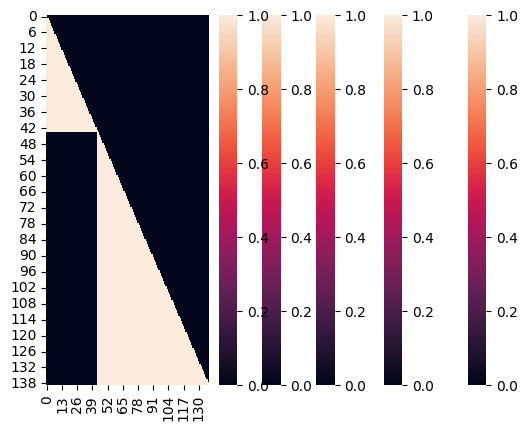

In [16]:
train_peft_model(m, learning_rate=1e-3)

# TRAINING LOOP V2

In [52]:
print(m.config())


AttributeError: 'Model' object has no attribute 'config'

In [53]:
def train_peft_model(model, num_epochs=5, learning_rate=1e-3):
    # Prepare the training data
    # input_text = "Generate the letter a: "
    # target_text = "a " * 20  # 20 'a' tokens
    # full_text = input_text + target_text
    gt_text = "Tell me about a weekend in a mountain cabin in 150 words and then tell me about disconnecting from technology in another 150 words. Only do that. Make sure you don’t add any headings or comments.\n\nThe scent of pine needles filled the air as we drove up the winding mountain road.  Our cozy cabin, nestled amongst towering trees, welcomed us with warmth and the promise of a peaceful escape.  Days were spent hiking through sun-dappled forests, the sound of birdsong our only soundtrack. Evenings were spent by the crackling fireplace, sharing stories and laughter. The stars, unfiltered by city lights, blazed across the night sky, a breathtaking spectacle.\n\nThe world seemed to fade away as I stepped away from the constant buzz of notifications and the endless scroll.  Silence, once a rarity, became a comforting presence.  I rediscovered the joy of reading a physical book, the pages turning slowly, each word savored.  Conversations flowed more deeply, unhurried and genuine.  Nature, with its gentle rhythms, became my guide, reminding me of the simple beauty of being present."
    # prompt = "Tell me about a weekend in a mountain cabin in 150 words and then tell me about disconnecting from technology in another 150 words. Only do that. Make sure you don’t add any headings or comments.\n\nThe scent of pine needles filled the air as we drove up the winding mountain road.  Our cozy cabin, nestled amongst towering trees, welcomed us with warmth and the promise of a peaceful escape.  Days were spent hiking through sun-dappled forests, the sound of birdsong our only soundtrack. Evenings were spent by the crackling fireplace, sharing stories and laughter. The stars, unfiltered by city lights, blazed across the night sky, a breathtaking spectacle.\n\n"
    tokenizer = model.tokenizer


    # Prepare optimizer and scheduler
    optimizer = AdamW(model.peft_predictor.parameters(), lr=learning_rate)
    total_steps = num_epochs * 10  # 10 steps per epoch
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Training loop
    model.peft_predictor.train()
    for epoch in range(num_epochs):

        for _ in range(1):  # 10 steps per epoch
            # outputs = model.peft_predictor(
            #     input_ids=input_ids,
            #     attention_mask=attention_mask,
            #     labels=labels
            # )
            # ------------- predictor loop insertion --------
            gt_len = len(tokenizer.tokenize(gt_text))
            inputs = tokenizer(gt_text, return_tensors="pt").to('cuda')

            dot_id = tokenizer.encode(".\n\n")[-1]
            # print(f"dot_id: {dot_id}, token: {tokenizer.convert_ids_to_tokens(dot_id)}")
            inputs['attention_mask'] = create_paragraph_attention_mask(inputs['input_ids'], dot_id, device=device)

            import seaborn as sns

            sns.heatmap(inputs['attention_mask'][0, 0].cpu().numpy())
            # print(inputs['attention_mask'].shape)

            # repeat attention mask
            inputs['attention_mask'] = einops.repeat(inputs['attention_mask'], 'batch 1 i j-> batch head i j', head=24)
            inputs['attention_mask'] = einops.rearrange(inputs['attention_mask'], "batch head x y -> batch head 1 x y")

            print(inputs['input_ids'].shape)
            print(inputs['attention_mask'].shape)
            # -----------------------------------------------
            with torch.no_grad():  # Wrap updates in no_grad
                acts_orig, logits_orig = get_model_activations(m_orig, gt_text)
                # replace_acts(model, text)
            acts_lora, logits_lora = get_model_activations(model, gt_text, attention_mask = inputs['attention_mask'])
            # acts_lora, logits_lora = get_model_activations(model, gt_text)

            logprobs_logits_lora = torch.nn.functional.log_softmax(logits_lora, dim=-1)
            probs_orig = torch.nn.functional.softmax(logits_orig, dim=-1)
                # Calculate loss
                # Calculate loss
            # print/compare logits and activations to one another first
            loss_acts = torch.nn.MSELoss()(acts_lora['attn'],acts_orig['attn'])
            loss_logits = torch.nn.CrossEntropyLoss()(logprobs_logits_lora,probs_orig)
            loss = loss_acts + loss_logits
            print(f"Epoch {epoch+1}/{num_epochs}, Acts Loss: {loss_acts.item():.4f}")
            print(f"Epoch {epoch+1}/{num_epochs}, Logits Loss: {loss_logits.item():.4f}")

            loss.backward()  # Backpropagate the loss

            # Update model parameters
            optimizer.step()  # Update parameters without tracking gradients
            # optimizer.zero_grad()  # Clear gradients for the next step

            optimizer.zero_grad()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    model.peft_predictor.eval()

/workspace/SPAR/interp-ab/.venv/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


torch.Size([1, 229])
torch.Size([1, 24, 1, 229, 229])


RuntimeError: The size of tensor a (128) must match the size of tensor b (229) at non-singleton dimension 5

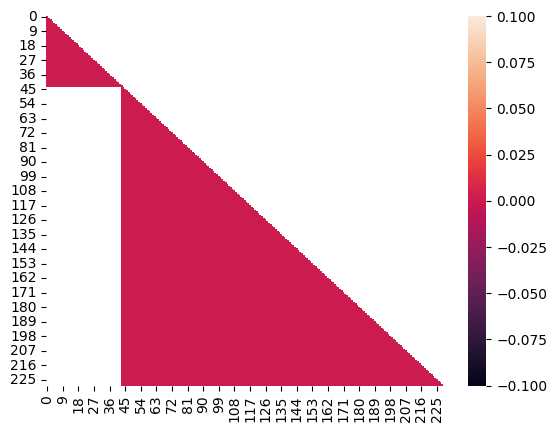

In [54]:
train_peft_model(m, learning_rate=1e-2)

## ORIG TRAINING LOOP

In [25]:
def train_peft_model(model, num_epochs=5, learning_rate=1e-3):
    # Prepare the training data
    # input_text = "Generate the letter a: "
    # target_text = "a " * 20  # 20 'a' tokens
    # full_text = input_text + target_text
    text = "Tell me about a weekend in a mountain cabin in 150 words and then tell me about disconnecting from technology in another 150 words. Only do that. Make sure you don’t add any headings or comments.\n\nThe scent of pine needles filled the air as we drove up the winding mountain road.  Our cozy cabin, nestled amongst towering trees, welcomed us with warmth and the promise of a peaceful escape.  Days were spent hiking through sun-dappled forests, the sound of birdsong our only soundtrack. Evenings were spent by the crackling fireplace, sharing stories and laughter. The stars, unfiltered by city lights, blazed across the night sky, a breathtaking spectacle.  \n\n"

    tokenizer = model.tokenizer

    # Ensure the tokenizer has a pad token
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Tokenize the full text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    input_ids = inputs.input_ids.to(model.device)
    attention_mask = inputs.attention_mask.to(model.device)

    # Create labels by shifting the input_ids to the right
    labels = input_ids.clone()
    labels[:, :-1] = input_ids[:, 1:]
    labels[:, -1] = -100  # Ignore the last token when computing loss

    # Prepare optimizer and scheduler
    optimizer = AdamW(model.peft_predictor.parameters(), lr=learning_rate)
    total_steps = num_epochs * 10  # 10 steps per epoch
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Training loop
    model.peft_predictor.train()
    for epoch in range(num_epochs):
        for _ in range(4):  # 10 steps per epoch
            outputs = model.peft_predictor(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            with torch.no_grad():  # Wrap updates in no_grad
                acts_orig, logits_orig = get_model_activations(m_orig, text)
                # replace_acts(model, text)
            acts_lora, logits_lora = get_model_activations(model, text)
            
            # Update model parameters
            optimizer.step()  # Update parameters without tracking gradients
            optimizer.zero_grad()  # Clear gradients for the next step

            loss.backward()  # Backpropagate the loss
            optimizer.zero_grad()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    model.peft_predictor.eval()